## Vertical Bias by Season

In [1]:
import argparse
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os 
import copy
from scipy import signal
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta


import matplotlib.pyplot as plt
import matplotlib as mpl
#import collections
import matplotlib.ticker as mticker
from matplotlib import ticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
import os

## Experiment Settings!

In [2]:
dir_exp = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo/ts/'
dir_cntrl = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNTRLmjo/ts/'
dir_obs = '/glade/campaign/cgd/amp/wchapman/Reanalysis/ERA5_obs/'

fin_exp = 'f.e.FTORCHmjo_CNNmjo.cam.h0.U.plev.197901-201012.nc'
fin_cntrl = 'f.e.FTORCHmjo_CNTRLmjo.cam.h0.U.plev.197901-201012.nc'
fin_obs = 'ERA5.an.sfc.pl.camgrid.1979-2022.nc'

var_cntrl = 'U'
var_exp = 'U'
var_obs = 'u'

file_path_cntrl = os.path.join(dir_cntrl, fin_cntrl)  # Join the directory and file name
file_path_exp = os.path.join(dir_exp, fin_exp)  # Join the directory and file name
file_path_obs = os.path.join(dir_obs, fin_obs)  # Join the directory and file name

DS_cntrl = xr.open_dataset(file_path_cntrl)
DS_exp = xr.open_dataset(file_path_exp)
DS_obs = xr.open_dataset(file_path_obs)

#time issues: 
datetimeindex = DS_cntrl.indexes['time'].to_datetimeindex()
DS_cntrl['time'] = datetimeindex

datetimeindex = DS_exp.indexes['time'].to_datetimeindex()
DS_exp['time'] = datetimeindex

DS_obs = DS_obs.rename({'level':'lev'}).sel(lev=DS_cntrl['lev'])

#latitude weighting.
weights_cos = np.cos(np.deg2rad(DS_cntrl.lat))
weights_cos.name = "weights"

print('...loading...')
DS_obs = DS_obs[var_obs].to_dataset(name=var_obs).load()
print('loaded Obs')
DS_cntrl = DS_cntrl[var_cntrl].to_dataset(name=var_cntrl).load()
print('loaded CNTRL')
DS_exp = DS_exp[var_exp].to_dataset(name=var_exp).load()
print('loaded EXP')

...loading...
loaded Obs
loaded CNTRL
loaded EXP


## Functions

In [3]:
def wgt_rmse(fld1, fld2, wgt):
    """Calculated the area-weighted RMSE.
    Inputs are 2-d spatial fields, fld1 and fld2 with the same shape.
    They can be xarray DataArray or numpy arrays.
    Input wgt is the weight vector, expected to be 1-d, matching length of one dimension of the data.
    Returns a single float value.
    """
    assert len(fld1.shape) == 2,     "Input fields must have exactly two dimensions."
    assert fld1.shape == fld2.shape, "Input fields must have the same array shape."
    # in case these fields are in dask arrays, compute them now.
    if hasattr(fld1, "compute"):
        fld1 = fld1.compute()
    if hasattr(fld2, "compute"):
        fld2 = fld2.compute()
    if isinstance(fld1, xr.DataArray) and isinstance(fld2, xr.DataArray):
        return (np.sqrt(((fld1 - fld2)**2).weighted(wgt).mean())).values.item()
    else:
        check = [len(wgt) == s for s in fld1.shape]
        if ~np.any(check):
            raise IOError(f"Sorry, weight array has shape {wgt.shape} which is not compatible with data of shape {fld1.shape}")
        check = [len(wgt) != s for s in fld1.shape]
        dimsize = fld1.shape[np.argwhere(check).item()]  # want to get the dimension length for the dim that does not match the size of wgt
        warray = np.tile(wgt, (dimsize, 1)).transpose()   # May need more logic to ensure shape is correct.
        warray = warray / np.sum(warray) # normalize
        wmse = np.nansum(warray * (fld1 - fld2)**2)
        return np.sqrt( wmse ).item()


def rmse_field(fld1, fld2):
    """Calculated the area-weighted RMSE.
    Inputs are 2-d spatial fields, fld1 and fld2 with the same shape.
    They can be xarray DataArray or numpy arrays.
    Input wgt is the weight vector, expected to be 1-d, matching length of one dimension of the data.
    Returns a single float value.
    """
    wmse = ((fld1 - fld2)**2)
    return np.sqrt( wmse )


def weighted_temporal_mean(ds, var):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out


def seasonal_averages(DS, vardo):
    month_length = DS.time.dt.days_in_month
    weights = (month_length.groupby("time.season") / month_length.groupby("time.season").sum())
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))
    DS_weighted = (DS * weights).groupby("time.season").sum(dim="time", skipna = False)

    return DS_weighted

def fix_dates(DS):
    stryr = f'{str(DS["time.year"][0].values)}-01-01'
    endyr = f'{str(DS["time.year"][-1].values-1)}-12-01'

    DT = pd.date_range(start = stryr, end = endyr, freq = 'MS')

    DS['time'] = DT

    return DS

## Time by season

In [4]:
DS_exp =fix_dates(DS_exp)
DS_cntrl =fix_dates(DS_cntrl)
print('..dates fixed...')
DS_cntrl_SA = seasonal_averages(DS_cntrl, var_cntrl)
print('..cntrl averaged...')
DS_exp_SA = seasonal_averages(DS_exp, var_exp)
print('..exp averaged...')
DS_obs_SA = seasonal_averages(DS_obs, var_obs)
print('..obs averaged...')

..dates fixed...
..cntrl averaged...
..exp averaged...
..obs averaged...


## RMSE

In [5]:
RMSE_exp_SA = rmse_field(DS_exp_SA[var_exp],DS_obs_SA[var_obs])
RMSE_cntrl_SA = rmse_field(DS_cntrl_SA[var_cntrl],DS_obs_SA[var_obs])

## Colormap

In [6]:
if var_cntrl == 'T':
    # define the colormap
    cmap = plt.cm.RdYlBu_r
    # extract all colors from the Reds map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # make the first color entry to be whhite
    # make the last color entry to be most extreme--
    
    cmap.N
    # create the new map
    cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
    clevels = np.arange(-100,105,5)
    norm = mpl.colors.BoundaryNorm(clevels, cmap.N)

elif var_cntrl == 'Q':
    print('in Q')
    # define the colormap
    cmap = plt.cm.RdYlBu_r
    # extract all colors from the Reds map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # make the first color entry to be whhite
    # make the last color entry to be most extreme--
    
    cmap.N
    # create the new map
    cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
    clevels = np.arange(-100,105,5)
    norm = mpl.colors.BoundaryNorm(clevels, cmap.N)

elif var_cntrl == 'U':
    # define the colormap
    cmap = plt.cm.RdYlBu_r
    # extract all colors from the Reds map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # make the first color entry to be whhite
    # make the last color entry to be most extreme--
    
    cmap.N
    # create the new map
    cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
    clevels = np.arange(-100,105,5)
    norm = mpl.colors.BoundaryNorm(clevels, cmap.N)
    
elif var_cntrl == 'V':
    # define the colormap
    cmap = plt.cm.RdYlBu_r
    # extract all colors from the Reds map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # make the first color entry to be whhite
    # make the last color entry to be most extreme--
    
    cmap.N
    # create the new map
    cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
    clevels = np.arange(-100,105,5)
    norm = mpl.colors.BoundaryNorm(clevels, cmap.N)
    
else: 
    # define the colormap
    cmap = plt.cm.RdYlBu_r
    # extract all colors from the Reds map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # make the first color entry to be whhite
    # make the last color entry to be most extreme--
    
    cmap.N
    # create the new map
    cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
    clevels = np.arange(-100,105,5)
    norm = mpl.colors.BoundaryNorm(clevels, cmap.N)

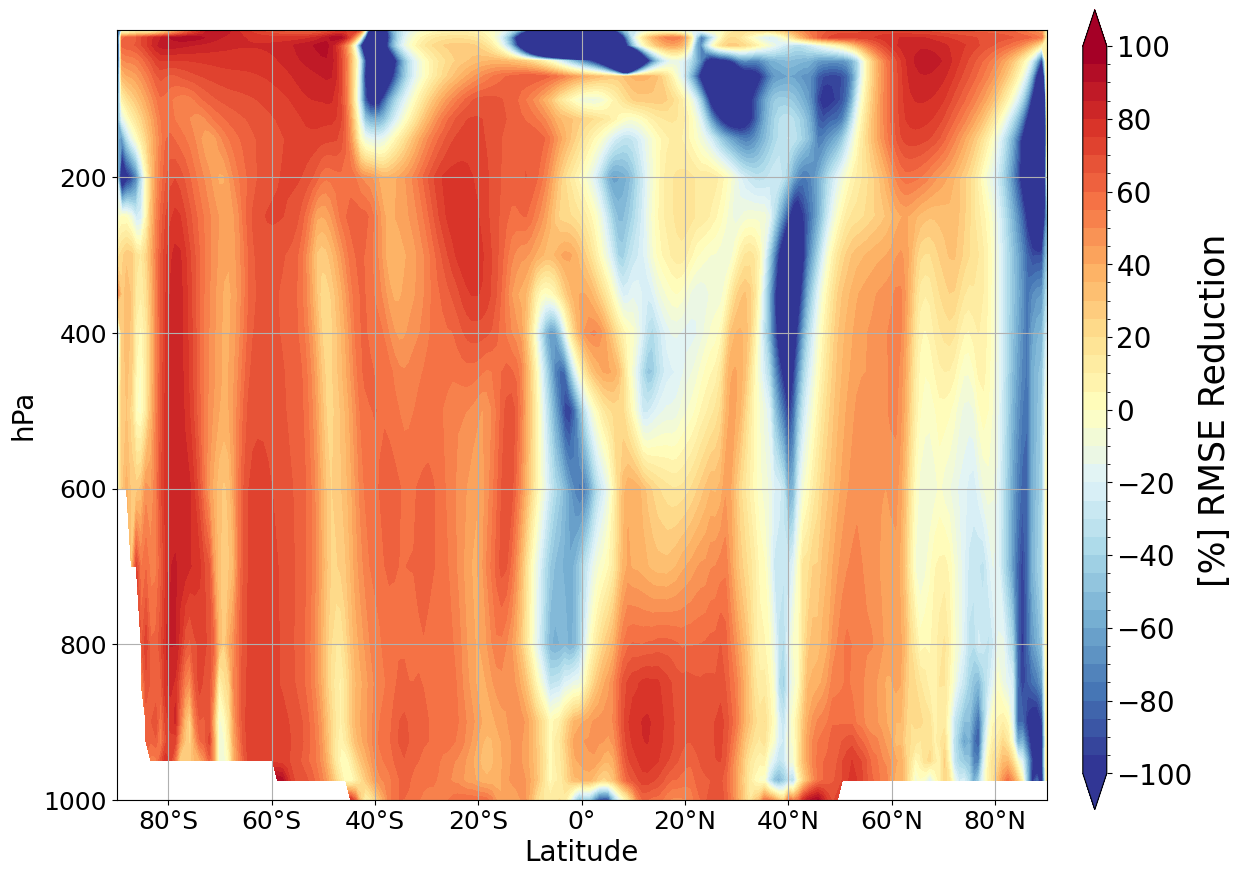

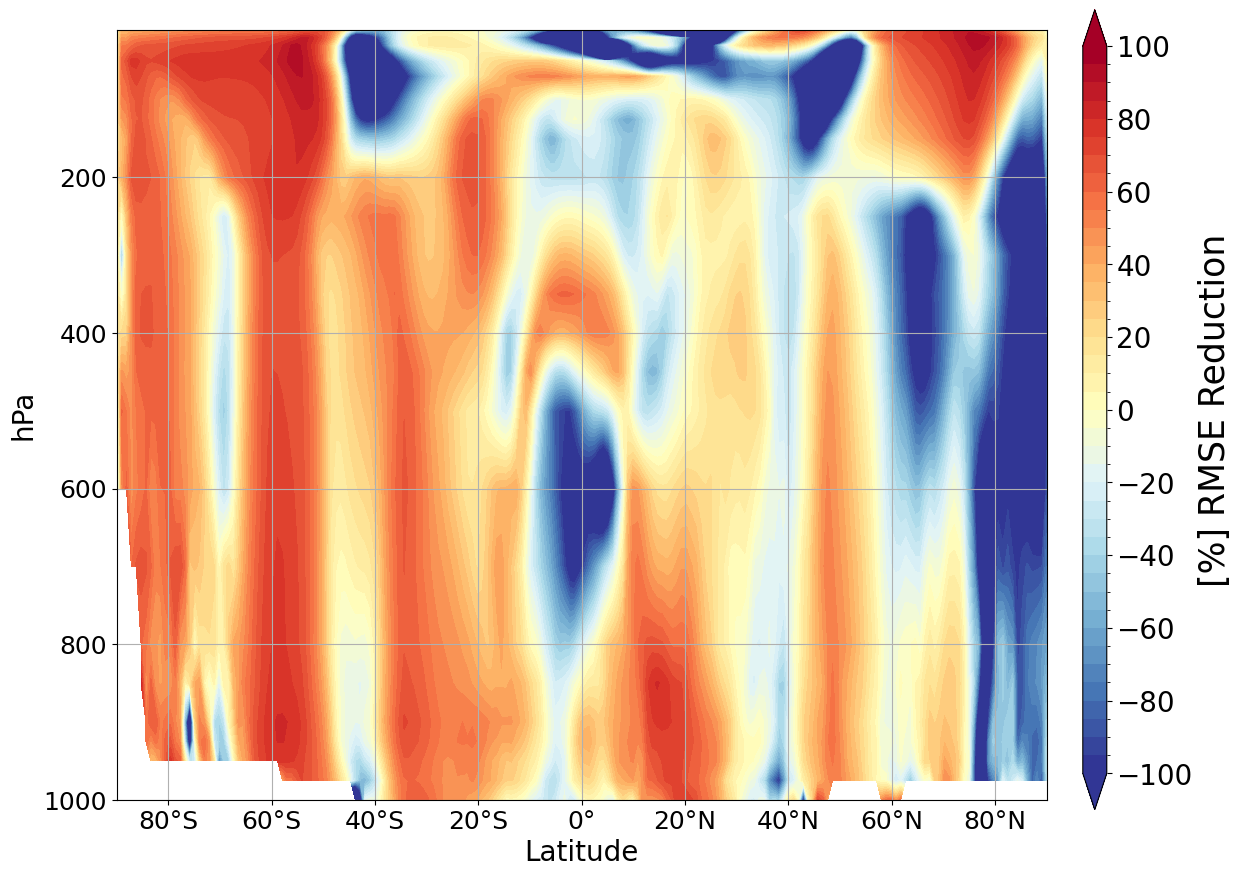

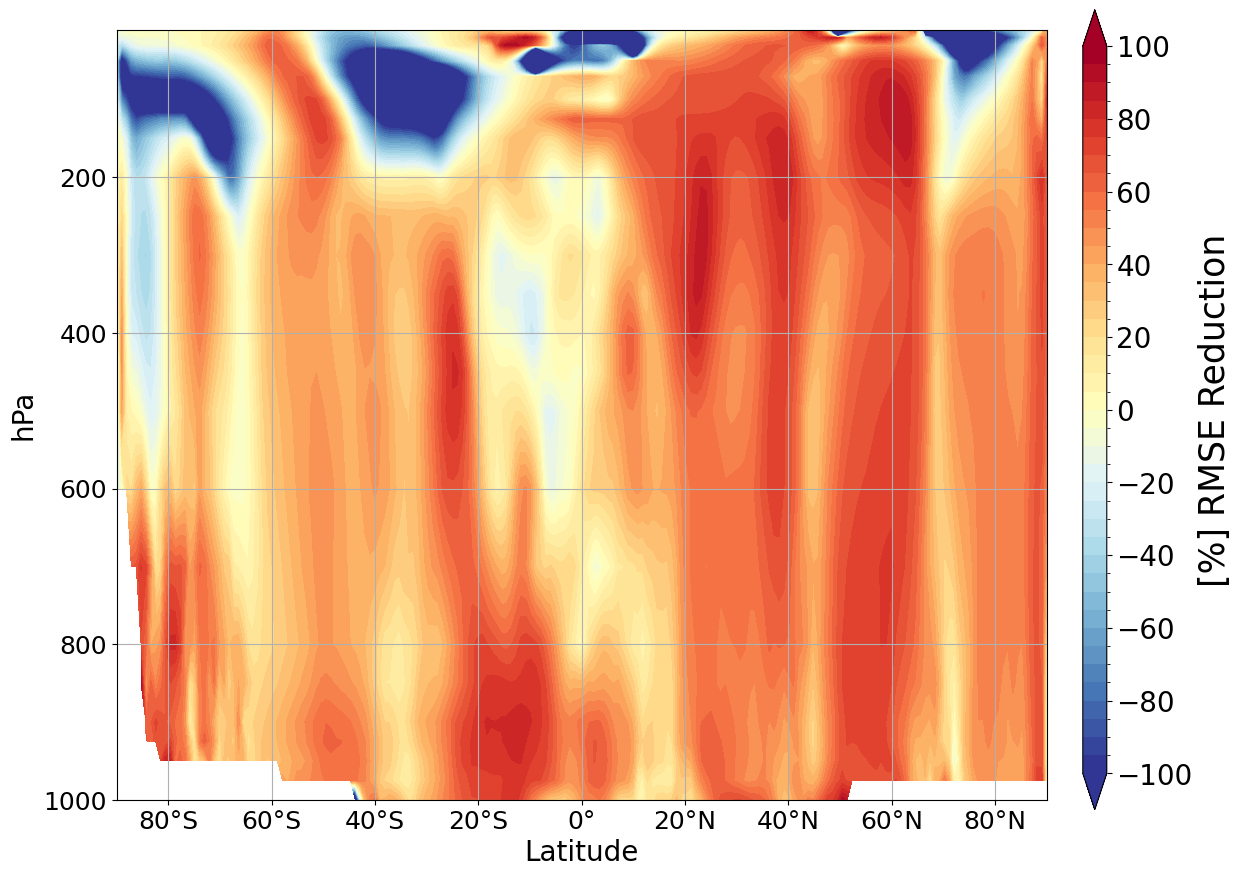

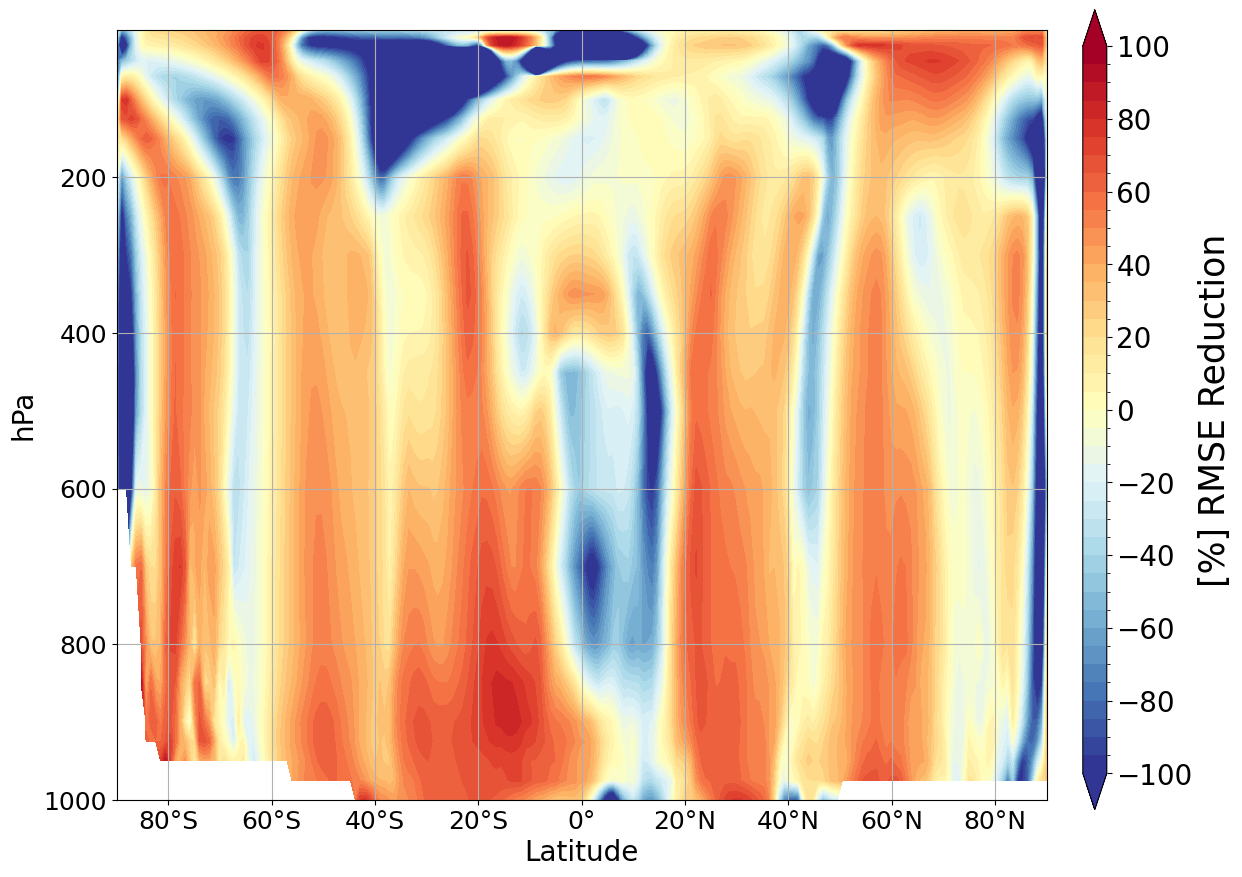

In [7]:
for SEAS in ['DJF','MAM','JJA','SON']:
    plotter = 100*((RMSE_cntrl_SA.sel(season=SEAS).mean('lon')-RMSE_exp_SA.sel(season=SEAS).mean('lon'))/(RMSE_cntrl_SA.sel(season=SEAS).mean('lon')))
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    lat = DS_cntrl_SA['lat']
    plevv = DS_cntrl_SA['lev']
    
    ff=plt.contourf(lat,plevv,plotter,levels=clevels,cmap=cmap,norm=norm,extend='both')
    
    plt.grid(True)
    plt.ylim([10,1000])
    plt.xlabel('Latitude',fontsize=20)
    plt.ylabel('hPa',fontsize=20)
    lat_formatter = LatitudeFormatter(number_format='.0f')
    plt.tick_params(labelsize=18) 
    ax.invert_yaxis()
    ax.xaxis.set_major_formatter(lat_formatter)
    
    # create the colorbar
    ax2 = fig.add_axes([0.93, 0.1, 0.02, 0.8])
    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, extend='both', spacing='proportional', ticks=clevels, boundaries=clevels)
    ax2.set_ylabel('[%] RMSE Reduction', size=25)
    cb.ax.tick_params(labelsize=20)
    tick_locator = ticker.MaxNLocator(nbins=10)
    cb.locator = tick_locator
    cb.update_ticks()
    
    
    ### +++ saving
    plt.savefig(f'{dir_exp}{SEAS}_{fin_exp}_vertical_RMSE.png', dpi=200,bbox_inches='tight')
    ### --- saving

In [8]:
weighted_dict = {}
for SEAS in ['DJF','MAM','JJA','SON']:
    weighted_rmse =[]
    for levs in RMSE_exp_SA['lev']:
        lv = int(levs.values)
    
        w1 = wgt_rmse(DS_cntrl_SA[var_exp].sel(lev=lv,season=SEAS),DS_obs_SA[var_obs].sel(lev=lv,season=SEAS),weights_cos)
        w2 = wgt_rmse(DS_exp_SA[var_exp].sel(lev=lv,season=SEAS),DS_obs_SA[var_obs].sel(lev=lv,season=SEAS),weights_cos)

        weighted_rmse.append(((w1-w2)/w1)*100)

    weighted_dict[SEAS]=weighted_rmse
    

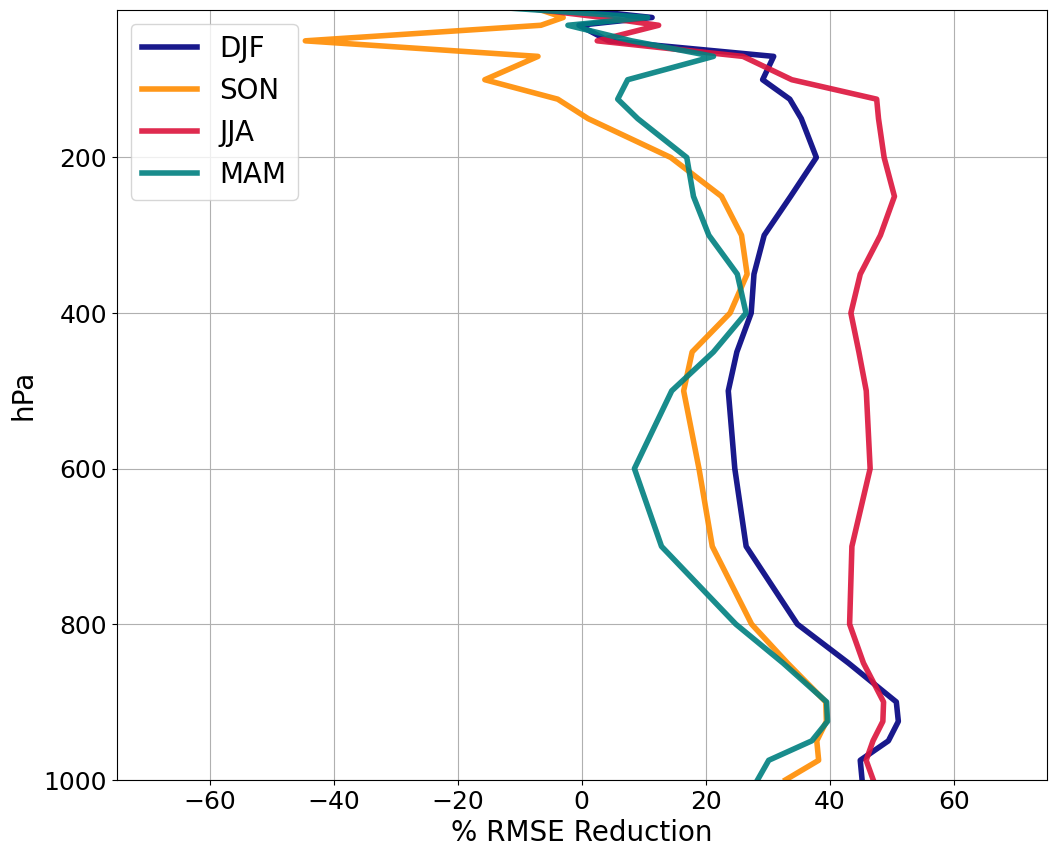

<Figure size 640x480 with 0 Axes>

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(weighted_dict['DJF'],np.array(RMSE_exp_SA['lev']),label='DJF',linewidth=4, alpha=0.9, color='navy')
ax.plot(weighted_dict['SON'],np.array(RMSE_exp_SA['lev']),label='SON',linewidth=4, alpha=0.9, color='darkorange')
ax.plot(weighted_dict['JJA'],np.array(RMSE_exp_SA['lev']),label='JJA',linewidth=4, alpha=0.9, color='crimson')
ax.plot(weighted_dict['MAM'],np.array(RMSE_exp_SA['lev']),label='MAM',linewidth=4, alpha=0.9, color='teal')
plt.ylim([10,1000])
plt.xlim([-75,75])
plt.xlabel('% RMSE Reduction',fontsize=20)
plt.ylabel('hPa',fontsize=20)
ax.invert_yaxis()
plt.legend(fontsize=20)
plt.tick_params(labelsize=18) 
plt.grid(True)
plt.show()
### +++ saving
plt.savefig(f'{dir_exp}{SEAS}_{fin_exp}_AllSeason_vertical_RMSE.png', dpi=200,bbox_inches='tight')
### --- saving
plt.show()

In [10]:
f'{dir_exp}{SEAS}_{fin_exp}_AllSeason_vertical_RMSE.png'

'/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo/ts/SON_f.e.FTORCHmjo_CNNmjo.cam.h0.U.plev.197901-201012.nc_AllSeason_vertical_RMSE.png'